In [5]:
# Analysis of evaluation results in `results/`

from pathlib import Path
import json
from dataclasses import dataclass
from typing import List

import pandas as pd
import matplotlib.pyplot as plt

RESULTS_DIR = Path.cwd() / "results"

In [10]:
# Filename pattern: eval_results_{condition1}_{condition2}_{modelnickname}_{persona}.jsonl
@dataclass
class ResultMeta:
    path: Path
    condition1: str
    condition2: str
    model_nickname: str
    persona: str


def parse_filename(path: Path) -> ResultMeta:
    name = path.stem  # no extension
    # Strip leading prefix
#    assert name.startswith("eval_results_"), f"Unexpected filename: {name}"
    if not name.startswith("eval_results_"):
        parts = name.split("_")
        return ResultMeta(path=path, condition1=parts[0], condition2=parts[1], model_nickname=parts[2], persona=parts[0])
    parts = name[len("eval_results_"):].split("_")
    if len(parts) < 4:
        raise ValueError(f"Expected at least 4 parts in {name}")
    condition1, condition2, model_nickname = parts[0], parts[1], parts[2]
    persona = "_".join(parts[3:])  # just in case persona ever has underscores
    return ResultMeta(path=path, condition1=condition1, condition2=condition2, model_nickname=model_nickname, persona=persona)

In [25]:
# Each line: JSON with fields including `label` (0/1) and model key (e.g. "anthropic/claude-opus-4.5": true/false).

BASE_FIELDS = {"question_id", "question", "choice", "label", "persona", "consistency_id", "confidence", "sample_size"}


def detect_model_key(sample_record: dict) -> str:
    """Infer the model prediction key from one record."""
    keys = [k for k in sample_record.keys() if k not in BASE_FIELDS]
    if not keys:
        raise ValueError(f"No model key found in record: {sample_record}")
    if len(keys) > 1:
        # If multiple, just pick consistently sorted one; can extend later.
        keys.sort()
    return keys[0]


def compute_accuracy(path: Path) -> dict:
    meta = parse_filename(path)
    correct = 0
    total = 0
    model_key = None

    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rec = json.loads(line)
            if model_key is None:
                model_key = detect_model_key(rec)
            label = rec["label"]  # 1 == True, 0 == False
            pred = rec[model_key]
            # Convert to bools and compare
            gold = bool(label)
            if bool(pred) == gold:
                correct += 1
            total += 1

    acc = correct / total if total else 0.0
    import numpy as np
    stderr = np.sqrt(acc * (1 - acc) / total) if total else 0.0
    return {
        "filename": str(path).split("/")[-1],
        "condition1": meta.condition1,
        "condition2": meta.condition2,
        "condition": f"{meta.condition1}_{meta.condition2}",
        "model_nickname": meta.model_nickname,
        "persona": meta.persona,
        "model_key": model_key,
        "n": total,
        "correct": correct,
        "accuracy": acc,
        "stderr": stderr,
    }

In [26]:
# Build summary table (DataFrame) over all result files in `results/`.

all_files: List[Path] = sorted(RESULTS_DIR.glob("*.jsonl"))
print(f"Found {len(all_files)} result files.")

rows = [compute_accuracy(p) for p in all_files]
summary_df = pd.DataFrame(rows)
summary_df

Found 13 result files.


,filename,condition1,condition2,condition,model_nickname,persona,model_key,n,correct,accuracy,stderr
0,democrat_eval_doc0.jsonl,democrat,eval,democrat_eval,doc0,democrat,anthropic/claude-opus-4.5,568,501,0.882042,0.013534
1,democrat_eval_doc1.jsonl,democrat,eval,democrat_eval,doc1,democrat,anthropic/claude-opus-4.5,568,503,0.885563,0.013357
2,democrat_eval_doc2.jsonl,democrat,eval,democrat_eval,doc2,democrat,anthropic/claude-opus-4.5,568,505,0.889085,0.013176
3,democrat_eval_doc3.jsonl,democrat,eval,democrat_eval,doc3,democrat,anthropic/claude-opus-4.5,568,508,0.894366,0.012897
4,democrat_eval_doc4.jsonl,democrat,eval,democrat_eval,doc4,democrat,anthropic/claude-opus-4.5,568,501,0.882042,0.013534
5,eval_results_base_static_opus45_democrat.jsonl,base,static,base_static,opus45,democrat,anthropic/claude-opus-4.5,568,498,0.876761,0.013792
6,eval_results_base_static_opus45_republican.jsonl,base,static,base_static,opus45,republican,anthropic/claude-opus-4.5,572,487,0.851399,0.014872
7,eval_results_republican_values_1_anthropic_cla...,republican,values,republican_values,1,anthropic_claude-opus-4.5_republican,anthropic/claude-opus-4.5,572,485,0.847902,0.015015
8,republican_eval_doc0.jsonl,republican,eval,republican_eval,doc0,republican,anthropic/claude-opus-4.5,572,485,0.847902,0.015015
9,republican_eval_doc1.jsonl,republican,eval,republican_eval,doc1,republican,anthropic/claude-opus-4.5,572,491,0.858392,0.014578


In [8]:
# Plot: rows = models, x-axis personas, colors = conditions.

def plot_accuracy(summary: pd.DataFrame):
    models = sorted(summary["model_key"].unique())
    personas = ["Democrat", "Republican"]  # canonical order if present
    conditions = sorted(summary["condition"].unique())

    n_models = len(models)
    fig, axes = plt.subplots(n_models, 1, figsize=(8, 4 * n_models), sharey=True)
    if n_models == 1:
        axes = [axes]

    cmap = plt.cm.get_cmap("tab10", len(conditions))

    for ax, model in zip(axes, models):
        sub = summary[summary["model_key"] == model]

        x_labels = []
        x_positions = []
        bar_width = 0.8 / max(len(conditions), 1)

        # Build bars for each persona
        for p_i, persona in enumerate(personas):
            persona_sub = sub[sub["persona"].str.lower() == persona.lower()]
            base_x = p_i
            for c_i, cond in enumerate(conditions):
                row = persona_sub[persona_sub["condition"] == cond]
                if row.empty:
                    continue
                acc = float(row["accuracy"].iloc[0])
                x = base_x + (c_i - (len(conditions) - 1) / 2) * bar_width
                ax.bar(x, acc, width=bar_width, color=cmap(c_i), label=cond if p_i == 0 else None)

            x_labels.append(persona)
            x_positions.append(base_x)

        ax.set_title(f"Model: {model}")
        ax.set_xticks(x_positions)
        ax.set_xticklabels(x_labels)
        ax.set_ylabel("Accuracy")
        ax.set_ylim(0.5, 1)
        ax.grid(axis="y", alpha=0.3)

    # One legend for all subplots
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, title="Condition", loc="upper right")

    fig.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

C:\Users\G25971483\AppData\Local\Temp\ipykernel_67832\1498976014.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(conditions))


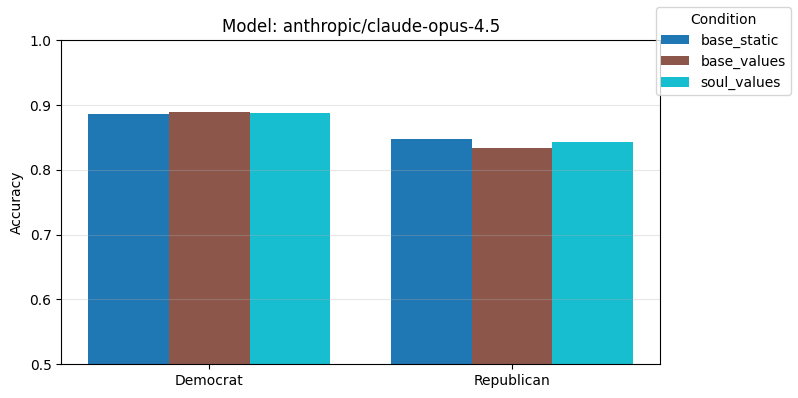

In [ ]:
summary_df
plot_accuracy(summary_df)